<a href="https://colab.research.google.com/github/vamshi-indla/My_Learnings/blob/master/Sunspots_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sunspots Forecast

### Download Dataset

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [30]:
!wget --no-check-certificate \
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
-O /tmp/sunspots.csv

--2020-05-30 04:05:11--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 2607:f8b0:400c:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-05-30 04:05:11 (120 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [0]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter = ',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

series = np.array(sunspots)
time = np.array(time_step)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

### Plot the data

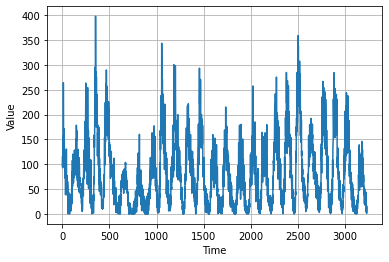

In [33]:
plot_series(time,series)

### Zoom in 

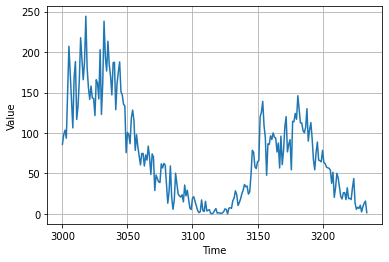

In [34]:
plot_series(time[3000:],series[3000:])

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Train the model with varying learning rates and find the best suited one

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
8/8 [==============================] - 1s 68ms/step - loss: 58.4196 - mae: 58.9175 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 1s 65ms/step - loss: 57.7190 - mae: 58.2167 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 1s 66ms/step - loss: 56.7194 - mae: 57.2170 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 1s 66ms/step - loss: 55.5877 - mae: 56.0849 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 1s 64ms/step - loss: 54.4490 - mae: 54.9460 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 1s 66ms/step - loss: 53.2946 - mae: 53.7916 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 1s 67ms/step - loss: 52.1635 - mae: 52.6605 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 1s 65ms/step - loss: 51.0383 - mae: 51.5353 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 1s 66ms/step - loss: 50.0782 - mae: 50.5753 - lr: 2.5

### Plot learning rate vs loss and identify best learning rate which offers low loss

(1e-08, 0.0001, 0.0, 30.0)

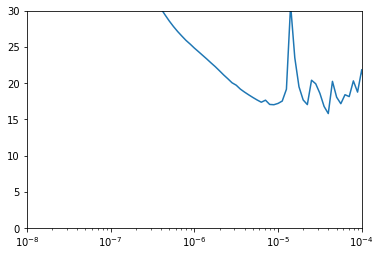

In [23]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

### Retrain the model with the best learning rate with more epochs

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 4s 119ms/step - loss: 38.9180 - mae: 39.4144
Epoch 2/500
30/30 [==============================] - 4s 119ms/step - loss: 25.7652 - mae: 26.2597
Epoch 3/500
30/30 [==============================] - 4s 122ms/step - loss: 22.0764 - mae: 22.5701
Epoch 4/500
30/30 [==============================] - 4s 121ms/step - loss: 20.4601 - mae: 20.9529
Epoch 5/500
30/30 [==============================] - 4s 121ms/step - loss: 19.7085 - mae: 20.2010
Epoch 6/500
30/30 [==============================] - 4s 121ms/step - loss: 19.3149 - mae: 19.8069
Epoch 7/500
30/30 [==============================] - 4s 121ms/step - loss: 18.7104 - mae: 19.2024
Epoch 8/500
30/30 [==============================] - 4s 121ms/step - loss: 18.1212 - mae: 18.6128
Epoch 9/500
30/30 [==============================] - 4s 120ms/step - loss: 18.0739 - mae: 18.5654
Epoch 10/500
30/30 [==============================] - 4s 120ms/step - loss: 17.9504 - mae: 18.4419
Epoch 11/500
30/30 

### Forecast on validation set

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

### Plot actual vs forecasted values

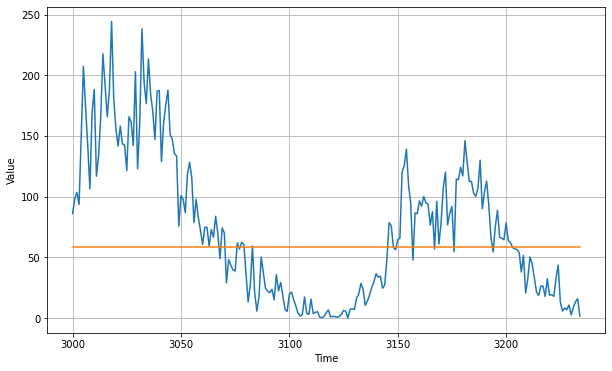

In [45]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

### Check mae

In [46]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

48.228413

In [0]:
### Plot mae, loss against epochs

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()